In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jupyter_black

jupyter_black.load()

In [3]:
from collections import defaultdict
from copy import deepcopy
from pprint import pprint

import numpy as np

from acoustics.plot import plot
from acoustics.porous_absorbers import materials, porous_absorber
from acoustics.rew import rew_rt60

In [4]:
# Data pulled from decay-time
%store -r area
%store -r volume
%store -r Tm
%store -r T_x
%store -r Tmin
%store -r Tmax
%store -r Sarequired

## Starting Decay Time

Our starting point is the fully furnished media-room (see furshings notebook in the media-room directory,) prior to any treatments being placed. Our goal here is to determine the best layout of porous absorbers to aim for our desired decay time (see decay-time notebook at the top-level.)

We'll start by loading the Topt data for the left channel and front right sub of the fully furnished room. We're loading both as the left channel speaker is a bookshelf style speaker that doesn't extend below 80Hz particually well. We'll then combine the Topt for these two speakers in a reasonable way to produce our starting point.

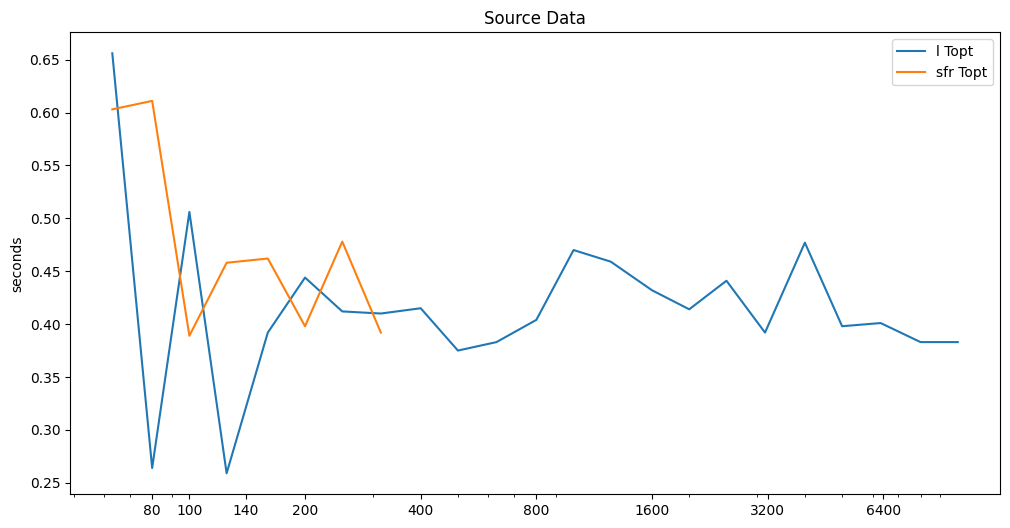

In [5]:
freq_l, _, Topt_l = rew_rt60(
    "../media-room/data/2024-04-16_screen/RT60_screen-p1-l.txt"
)
freq_sfr, _, Topt_sfr = rew_rt60(
    "../media-room/data/2024-04-16_screen/RT60_screen-p1-srf.txt"
)

ax = plot(
    freq_l,
    {
        "l Topt": (freq_l, Topt_l),
        "sfr Topt": (freq_sfr, Topt_sfr),
    },
    title="Source Data",
)
ax.set_ylabel("seconds")
None

In [6]:
# the l sweep was full range
freq = freq_l
# but the power generated at the lower end by the bookshelves isn't great,
# so take < 160 from the sub and > 160 from left
Topt = np.concatenate((Topt_sfr[:4], Topt_l[4:]))

## Target Decay Time

See the decay-time notebook for related calculations, but here we're using a slightly more forgiving target than Tm across all frequencies as hitting that level would require more absorption that we can reasonable fit into the room as well as a lot of very targeted low frequencies absorption. 

We'll instead aim for the middleground halfway between Tmax and Tmin with it's allowed uptick in low freqencies. We're going to ignore decrease in Tmin above 4k, we don't sepcifically want to decrease the time up there.

This should allow us to get a better overall match to what's acceptable (within Tmax and Tmin) without skewing our fit towards the lower frequencies where Tm is further from Tmax.

In [7]:
x0 = T_x[0]
# calculate the slope from the maximum line which we have exact points for
# mx + b = y
# m = (y2-y1) / (x2-x1)
m = (Tm - Tm * 1.5) / (T_x[1] - x0)
# we'll use that slope, but look for a y-intercept that's "ideal" (picked by me) and not max with some rise to get "warmth"
# mx + b = y
# b = y - mx
b = Tm * 1.5 - m * x0
# The low part of Tmax is linear on a logrithmic scale, we want to preserve that for our Ttarget, but we can't use
# logarithmic X values with our linear fit so we'll create linear X's to use for the section of things we're working with
dx = (T_x[1] - T_x[0]) / 5
Ttarget = np.array(
    (
        (x0) * m + b,  # 63
        (x0 + dx) * m + b,  # 80
        (x0 + 2 * dx) * m + b,  # 100
        (x0 + 3 * dx) * m + b,  # 125
        (x0 + 4 * dx) * m + b,  # 160
        (x0 + 5 * dx) * m + b,  # 200
        Tm,  # 250
        Tm,  # 315
        Tm,  # 400
        Tm,  # 500
        Tm,  # 630
        Tm,  # 800
        Tm,  # 1000
        Tm,  # 1250
        Tm,  # 1600
        Tm,  # 2000
        Tm,  # 2500
        Tm,  # 3150
        Tm,  # 4000
        Tm,  # 5000
        Tm,  # 6300
        Tm,  # 8000
        Tm,  # 10000
    )
)

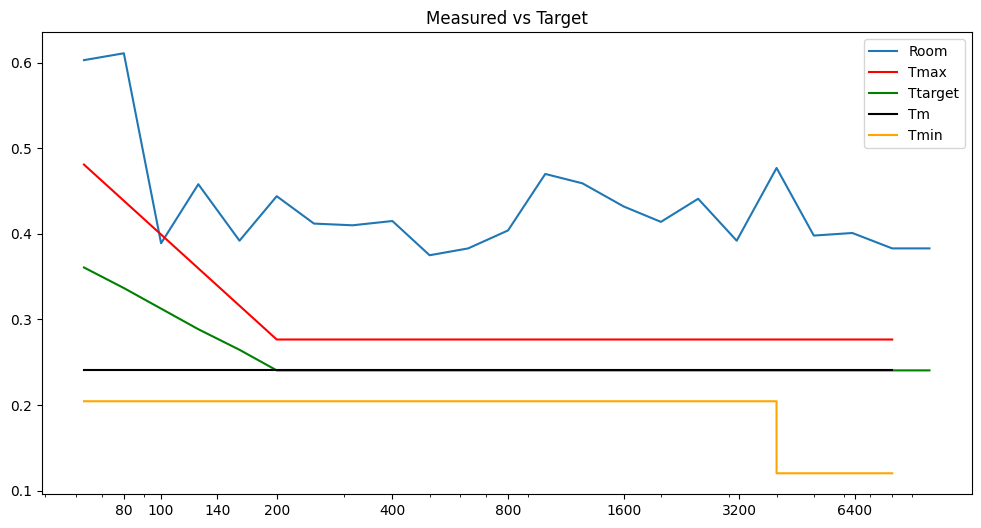

In [8]:
ax = plot(
    freq_l,
    {
        "Room": (freq, Topt),
        "Tmax": (T_x, Tmax, {"color": "red"}),
        "Ttarget": (freq, Ttarget, {"color": "green"}),
        "Tm": (T_x, [Tm for _ in T_x], {"color": "black"}),
        "Tmin": (T_x, Tmin, {"color": "orange"}),
    },
    title="Measured vs Target",
)
None

So we're in decent shape, but still have around 200ms to reduce across the whole spectrum. We'll start by calculating the required time reduction for each frequency and then compute the current Sabines of the room, and finally determine the additional Sabines needed to reach the target.

In [9]:
Tneeded = Ttarget - Topt
Saroom = (0.161 * volume) / Topt
Satarget = (0.161 * volume) / Ttarget
Saneeded = Satarget - Saroom

print("   freq   Topt Tneeded   Saroom Saneeded")
for fq, tc, tn, sr, sn in zip(freq, Topt, Tneeded, Saroom, Saneeded):
    print(f"{fq:5.0f}Hz {tc:.3f}s {tn:.3f}s {sr:.3f}sa {sn:.3f}sa")

   freq   Topt Tneeded   Saroom Saneeded
   63Hz 0.603s -0.242s 13.751sa 9.237sa
   80Hz 0.611s -0.274s 13.571sa 11.059sa
  100Hz 0.389s -0.076s 21.317sa 5.208sa
  125Hz 0.458s -0.169s 18.105sa 10.630sa
  160Hz 0.392s -0.127s 21.153sa 10.194sa
  200Hz 0.444s -0.204s 18.676sa 15.806sa
  250Hz 0.412s -0.172s 20.127sa 14.356sa
  315Hz 0.410s -0.170s 20.225sa 14.258sa
  400Hz 0.415s -0.175s 19.981sa 14.501sa
  500Hz 0.375s -0.135s 22.112sa 12.370sa
  630Hz 0.383s -0.143s 21.650sa 12.832sa
  800Hz 0.404s -0.164s 20.525sa 13.957sa
 1000Hz 0.470s -0.230s 17.643sa 16.840sa
 1250Hz 0.459s -0.219s 18.066sa 16.417sa
 1600Hz 0.432s -0.192s 19.195sa 15.288sa
 2000Hz 0.414s -0.174s 20.029sa 14.453sa
 2500Hz 0.441s -0.201s 18.803sa 15.679sa
 3150Hz 0.392s -0.152s 21.153sa 13.329sa
 4000Hz 0.477s -0.237s 17.384sa 17.099sa
 5000Hz 0.398s -0.158s 20.835sa 13.648sa
 6300Hz 0.401s -0.161s 20.679sa 13.804sa
 8000Hz 0.383s -0.143s 21.650sa 12.832sa
10000Hz 0.383s -0.143s 21.650sa 12.832sa


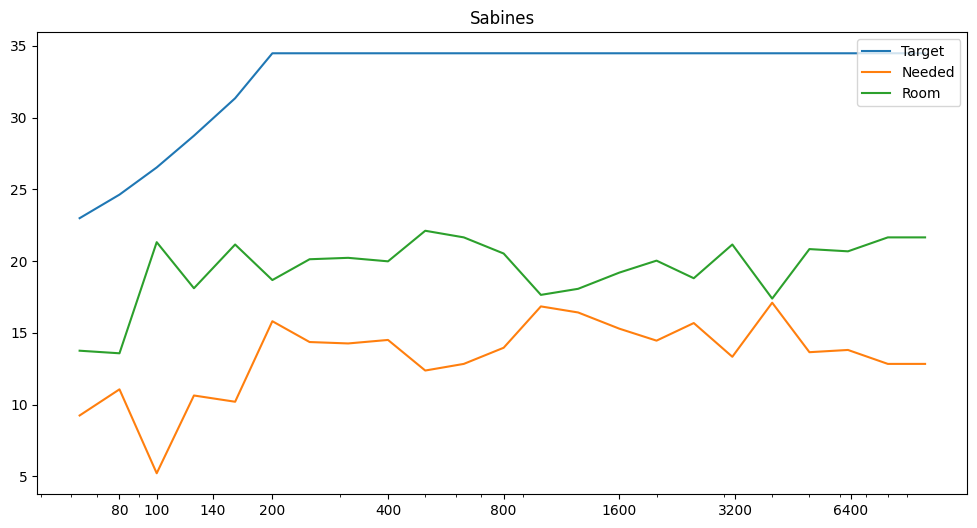

In [10]:
ax = plot(
    freq,
    {
        "Target": Satarget,
        "Needed": Saneeded,
        "Room": Saroom,
    },
    title="Sabines",
)

## Treatment Options

We'll first build up a list of treatments and our options for filling them with one or more layers of material.

In [11]:
max_options = 99999

fills = defaultdict(list)
for name, width, height, depth, min_air_gap in (
    ("Front", 28.5 * 0.0254, 35.00 * 0.0254, 4.0 * 0.0254, 0 * 0.0254),
    ("Side", 28.5 * 0.0254, 39.75 * 0.0254, 8.0 * 0.0254, 0 * 0.0254),
    ("Back", 28.5 * 0.0254, 51.00 * 0.0254, 12.0 * 0.0254, 0 * 0.0254),
    ("Back Slim", 14.5 * 0.0254, 51.00 * 0.0254, 4.0 * 0.0254, 0 * 0.0254),
    ("Cloud", 24 * 0.0254, 24 * 0.0254, 6.0 * 0.0254, 4 * 0.0254),
):
    for fill, info in materials.items():
        thickness = info["thickness"]
        if thickness > depth:
            continue
        layers = np.floor(depth / thickness)
        air_gap = depth - (thickness * layers)
        a = porous_absorber(
            freq, sigma=info["sigma"], thickness=thickness, air_gap=air_gap
        )
        if layers > 1:
            label = f"{layers}x {fill}"
        else:
            label = fill
        fills[name].append(
            {
                "label": f"{label} + {air_gap*1000:.0f}mm",
                "a": a,
                "area": width * height,
                "Sa": width * height * a,
                "ratio": thickness / depth,
            }
        )

# this isn't stickly necessary, but it sorts each option's fills by the % of the depth filled
# with absorbent and makes looking over the data easier to grok
for name, data in fills.items():
    data.sort(key=lambda d: d["ratio"], reverse=True)
    #
    fills[name] = data[:max_options]

# get rid of the defaultdict now so that we don't accidentally create empty k/v down below
fills = dict(fills)

## Fitting functions

The next two cells are where the details of the search are implemented. The first enunmerates all of the options by picking a fill for each slot repeatedly until all fill options have been in tried with all others. As should hopefully be obvious the number of permutations grows VERY quickly.

The next cell runs a fitting. Walking through all of the enumerated options keeping track of the one that best matches the the target decay time across all frequencies.

We'll also caclulate the total area covered with absorption so that we can compare it to the ~15% guidline mentioned in Per https://youtu.be/se1KlwXF2L8?si=VNEVb3pDUAPgHH_C&t=1303.

In [12]:
def enumerate_options(Sa, slots, chosen=[], area=0, fill_filter=None):
    if not slots:
        yield chosen, Sa, area
        return

    # make a copy so that we don't alter the original
    slots = list(slots)
    slot_name, slot_data = slots.pop(0)
    fill_options = fills[slot_data["fills"]]
    count = slot_data["count"]
    for fill in fill_options:
        label = fill["label"]
        if fill_filter and not fill_filter(fill):
            continue
        yield from enumerate_options(
            Sa + (count * fill["Sa"]),
            # pass along the remaining slots that need to be chosen from
            slots,
            chosen=chosen + [(slot_name, f"{count} - {label}")],
            area=area + (count * fill["area"]),
            fill_filter=fill_filter,
        )

In [13]:
def fit(slots, fill_filter=None):
    count = 0
    best_fit = 999999
    best = None
    for chosen, Sa, treatment_area in enumerate_options(
        Saroom, slots.items(), fill_filter=fill_filter
    ):
        count += 1
        fit = np.linalg.norm(Satarget - Sa)
        if fit < best_fit:
            best = {
                "fit": fit,
                "chosen": chosen,
                "Sa": Sa,
                "area": treatment_area,
                "coverage": treatment_area / area * 100,
                "Tm": 0.161 * volume / Sa,
            }
            best_fit = fit
    return best, count

## Treatment Placements

Finally we need to specify all of our treatment counts. This combines locations and with specific fills. In our case each location has a specific size, so the locations to treatments are essentially one to one, but keep in mind that the each of the treatments may have many fill options that could be placed in them. This would look very different if we had a setup of standard 4'x2' panels options that could be placed around the room.

In [14]:
best = {}

config = {
    "FR": {
        # primary first reflection require an absorber on both sides
        "fills": "Front",
        "count": 2,  # left & right
    },
    "Front": {
        "fills": "Front",
        "count": 4,  # 2 high left, 2 high right
    },
    # Side
    "Side": {
        "fills": "Side",
        "count": 2,
    },
    # Back
    "Back": {
        "fills": "Back",
        "count": 1,
    },
    # Back Slim
    "Back Slim": {
        "fills": "Back Slim",
        "count": 1,
    },
    # Cloud - these are big and divided into small cells to have smaller gaps since they're
    # horizontally oriented. We'll keep them symetrical across the center of the room
    "Cloud 1": {
        "fills": "Cloud",
        "count": 6,
    },
    "Cloud 2": {
        "fills": "Cloud",
        "count": 6,
    },
}


def all(fill):
    return True


def owens_corning(fill):
    label = fill["label"]
    # these are the materials i already have some of
    return "OC Fire & Sound Plus R-15" in label or "OC EcoTouch R-34.2*" in label


def rockwool_and_jm(fill):
    label = fill["label"]
    # these are the materials i already have some of
    return 'RW Safe n Sound 3"' in label or "JM R-30" in label


for name, config, fill_filter in (
    ("all", config, all),
    ("owens corning", config, owens_corning),
    ("rockwool and jm", config, rockwool_and_jm),
):
    best[name], count = fit(config, fill_filter=fill_filter)
    print(f"{count} configurations evaluated for {name}")

2729376 configurations evaluated for all
1 configurations evaluated for owens corning
2 configurations evaluated for rockwool and jm


# Results

So this is super interesting. If you look at the performance of RW Safe n Sound 3" and OC Fire & Sound Plus R-15 for 4" treatments in the rigid-backed-porous-absorber notebook you can see that the Rockwool has more absorption in the midrange and the Owens Corning is weaker there, but extends a bit further down in frequency. It gets even more complicated when air gaps are involved. Comparing all possible fills to runs where we're restricting things to Owens Corning or Rockwool results in a non-negligible modeled differences from 400Hz down once the differences are combined across a number of devices. 

For thinner devices higher flow resistivity is preferable, but thicker devices beenfit from lower resistivity materails, but air gaps complicate this even further. See the thickness-and-flow-resistivity notebook for more on this.

It would be interesting to compare all of this with real world tests, but that would involve buying 3x the required materials and the stuff is pretty messying to work with so swapping it in/out would be less than idea. Mostly planning to go with what's predicated as optimal here, the 'all' case. There will be plenty of incremental testing as things are built & placed.

Note: Unfortunately there is a dearth of quality flow resistivity numbers for available "pink" fiberglass insulation. So it's unlikely the material used will exactly match that picked in calculations here.

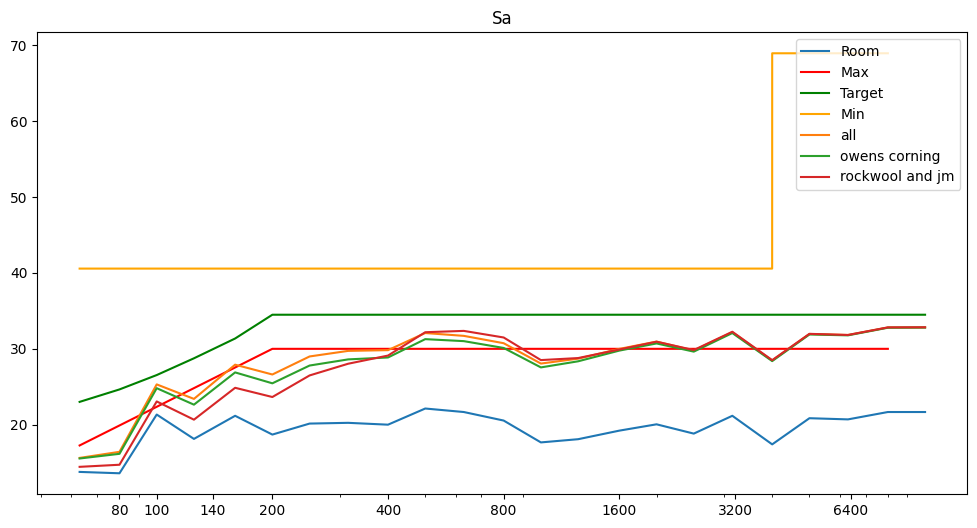

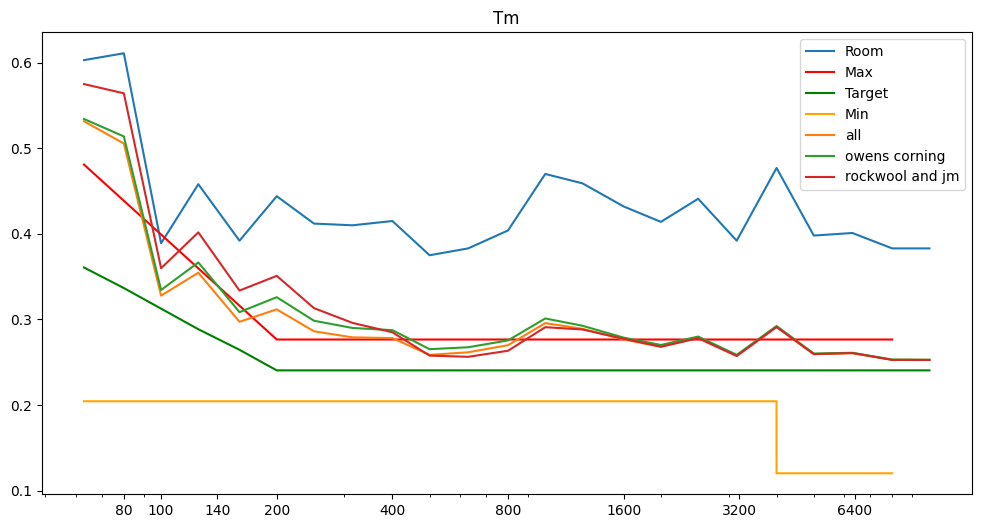

In [15]:
ax = plot(
    freq,
    dict(
        {
            "Room": Saroom,
            "Max": (T_x, (0.161 * volume) / np.array(Tmax), {"color": "red"}),
            "Target": (freq, Satarget, {"color": "green"}),
            "Min": (T_x, (0.161 * volume) / np.array(Tmin), {"color": "orange"}),
        },
        **{n: b["Sa"] for n, b in best.items()}
    ),
    title="Sa",
)
ax = plot(
    freq,
    dict(
        {
            "Room": Topt,
            "Max": (T_x, Tmax, {"color": "red"}),
            "Target": (freq, Ttarget, {"color": "green"}),
            "Min": (T_x, Tmin, {"color": "orange"}),
        },
        **{n: b["Tm"] for n, b in best.items()}
    ),
    title="Tm",
)
None

Per https://www.aes.org/technical/documents/AESTD1001.pdf adjacent octave bands should be ±5%, this doesn't take into account the allowed rise below 200Hz.

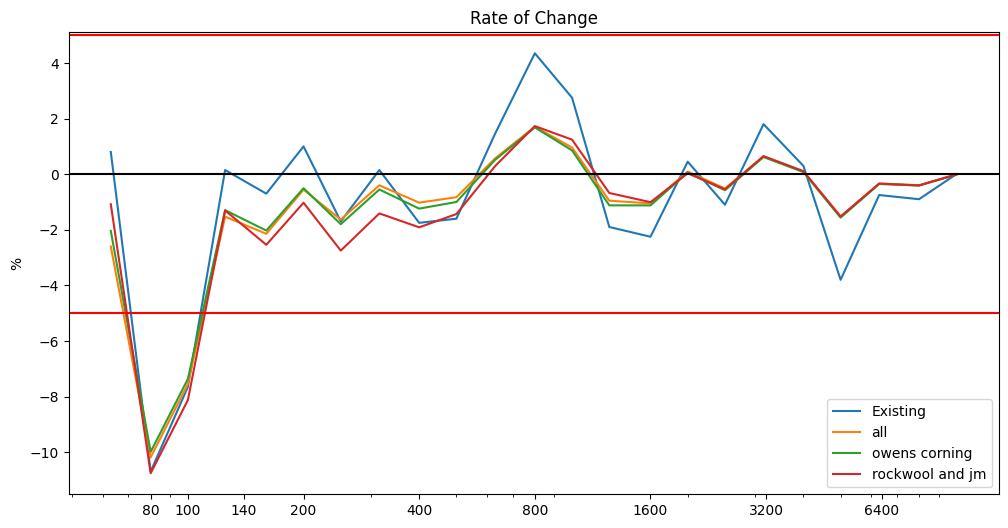

In [16]:
ax = plot(
    freq,
    dict(
        {
            "Existing": np.gradient(Topt) * 100,
        },
        **{n: np.gradient(b["Tm"]) * 100 for n, b in best.items()}
    ),
    title="Rate of Change",
    loc="lower right",
)
ax.set_ylabel("%")
ax.axhline(5, color="red")
ax.axhline(0, color="black")
ax.axhline(-5, color="red")
None

In [17]:
result = best['all']
print(f'{result['coverage']:0.2f}% of the room surfaces are covered with porous absorbent, target is roughly 15%')

16.81% of the room surfaces are covered with porous absorbent, target is roughly 15%


In [18]:
pprint(sorted(best.items(), key=lambda d: d[1]["fit"]))

[('all',
  {'Sa': array([15.59903387, 16.40106514, 25.29370018, 23.38227163, 27.89366381,
       26.59957011, 28.97845981, 29.71406969, 29.81045365, 32.06759968,
       31.6955309 , 30.72593783, 28.04135895, 28.68822303, 29.97362272,
       30.93908419, 29.76918999, 32.18075109, 28.45634821, 31.94300698,
       31.81083308, 32.80150379, 32.81411581]),
   'Tm': array([0.53157981, 0.50558493, 0.32783386, 0.35463327, 0.29727652,
       0.3117393 , 0.28614811, 0.27906414, 0.27816187, 0.25858285,
       0.26161832, 0.26987399, 0.29571076, 0.28904305, 0.27664762,
       0.26801477, 0.27854743, 0.25767365, 0.2913983 , 0.25959145,
       0.26067005, 0.2527973 , 0.25270013]),
   'area': 11.197235669999998,
   'chosen': [('FR', '2 - OC Fire & Sound Plus R-15 + 13mm'),
              ('Front', '4 - OC Fire & Sound Plus R-15 + 13mm'),
              ('Side', '2 - JM R-21 + 64mm'),
              ('Back', '1 - JM R-30 + 44mm'),
              ('Back Slim', '1 - OC Fire & Sound Plus R-15 + 13mm'),
     